## Load

In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from model_params import doubling_time
from model_data import model_data

print("Loaded libraries")

## START task length (displayed in sec) ##
{1: 1.0,
 5: 1.0,
 10: 1.0,
 20: 1.0,
 30: 1.85,
 40: 3.94,
 50: 7.76,
 60: 15.13,
 70: 30.55,
 80: 68.47,
 90: 220.44,
 95: 574.91,
 99: 3025.79}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 51,
 10: 80,
 20: 139,
 30: 206,
 40: 290,
 50: 399,
 60: 550,
 70: 772,
 80: 1148,
 90: 1981,
 95: 3149,
 99: 7287}



## DOUBLING TIME (displayed in days) ##
{1: 83,
 5: 105,
 10: 119,
 20: 139,
 30: 156,
 40: 171,
 50: 187,
 60: 204,
 70: 225,
 80: 251,
 90: 293,
 95: 334,
 99: 420}



## SHIFT (displayed in days) ##
{1: 0,
 5: 30,
 10: 57,
 20: 88,
 30: 112,
 40: 132,
 50: 150,
 60: 168,
 70: 188,
 80: 211,
 90: 243,
 95: 269,
 99: 320}
Loaded libraries


## Longer-term METR Predictions

In [2]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
ref_model = 'gpt5'
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at {model_data[ref_model]['performance_50p']:.1f}hr on {model_data[ref_model]['launch_date'].strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
for year in range(2025, 2030):
    start_q = 4 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}"
)
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - model_data[ref_model]['launch_date']).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = model_data[ref_model]['performance_50p'] * (2**doublings)

    task_lengths = np.minimum(task_lengths, 2000)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.3hr on 2025-08-07

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q4       2025-12-31   4.2hr      3.9hr      [3.1hr - 6.0hr]            146

2026Q1       2026-03-31   6.2hr      5.5hr      [3.7hr - 1.3d]             236
2026Q2       2026-06-30   1.2d       7.7hr      [4.5hr - 2.5d]             327
2026Q3       2026-09-30   1.9d       1.3d       [5.5hr - 4.5d]             419
2026Q4       2026-12-31   3.1d       1.9d       [6.6hr - 1.6wk]            511

2027Q1       2027-03-31   1.0wk      2.6d       [8.0hr - 3.0wk]            601
2027Q2       2027-06-30   1.7wk      3.7d       [1.2d - 5.4wk]             692
2027Q3       2027-09-30   2.8wk      1.0wk      [1.5d - 9.9wk]             784
2027Q4       2027-12-31   4.2wk      1.5wk      [1.8d - 18.2wk]            876

2028Q1       2028-03-3

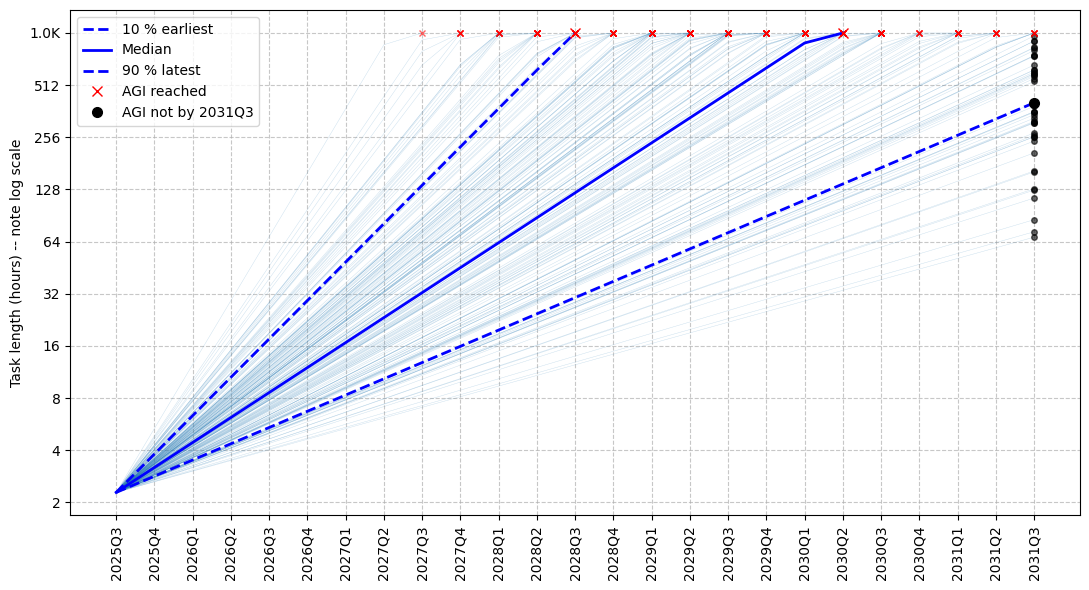

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=model_data[ref_model]['performance_50p'],
    start_date=model_data[ref_model]['launch_date'],
    agi_task_length=100_000,
    shift=0,
    n_quarters=24,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

## Shorter-term predictions

#### Predict Claude 4 Opus

In [4]:
def predict(from_model, for_model, debug=False):
    if isinstance(from_model, str):
        from_model = model_data[from_model]
    if isinstance(for_model, str):
        for_model = model_data[for_model]

    print(f"PREDICT {from_model['name']} -> {for_model['name']}")
    days_since = (for_model['launch_date'] - from_model['launch_date']).days

    def extrapolation():
        individual_model_idiosyncratic_variation = sq.norm(0.75, 1/0.75, lclip=0.1)
        doublings = days_since / doubling_time
        return from_model['performance_50p'] * (2**doublings) * individual_model_idiosyncratic_variation

    if debug:
        return {'from_model': from_model,
                'for_model': for_model,
                'days_since': days_since,
                'doubling_time': doubling_time,
                'doublings': days_since / doubling_time,
                'from_perf': from_model['performance_50p']}
    else:
        samples = sq.sample(extrapolation, n=50_000, verbose=True)
        mean_ci = sq.get_mean_and_ci(samples, credibility=80)
        print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
    
        if for_model.get('performance_50p'):
            print(f"Actual observed: {for_model['name']} at {for_model['performance_50p']:.1f}hr")
        return samples

_ = predict(from_model='o3', for_model='claude_4_opus')

PREDICT o3 -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9054.10it/s]

Predicted: 2.1hr (80%CI: 1.6hr - 2.6hr)
Actual observed: Claude 4 Opus at 1.3hr


In [5]:
_ = predict(from_model='claude_3p7_sonnet', for_model='claude_4_opus')

PREDICT Claude 3.7 Sonnet -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9013.26it/s]

Predicted: 1.5hr (80%CI: 1.1hr - 1.9hr)
Actual observed: Claude 4 Opus at 1.3hr


In [6]:
_ = predict(from_model='claude_3p5_sonnet_new', for_model='claude_4_opus')

PREDICT Claude 3.5 Sonnet (new) -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8968.84it/s]

Predicted: 1.2hr (80%CI: 44min - 1.7hr)
Actual observed: Claude 4 Opus at 1.3hr


#### Predict GPT5

In [7]:
_ = predict(from_model='o3', for_model='gpt5')

PREDICT o3 -> GPT5


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9034.09it/s]

Predicted: 2.9hr (80%CI: 2.1hr - 3.8hr)
Actual observed: GPT5 at 2.3hr


In [8]:
_ = predict(from_model='o1', for_model='gpt5')

PREDICT o1 -> GPT5


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9025.90it/s]

Predicted: 1.9hr (80%CI: 1.1hr - 2.9hr)
Actual observed: GPT5 at 2.3hr


#### Predict Claude 4.5 Sonnet

In [9]:
_ = predict(from_model='o3', for_model='claude_4p5_sonnet')

PREDICT o3 -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9028.44it/s]


Predicted: 3.6hr (80%CI: 2.4hr - 5.0hr)
Actual observed: Claude 4.5 Sonnet at 1.9hr


In [10]:
c4_samples = predict(from_model='claude_4_opus', for_model='claude_4p5_sonnet')

PREDICT Claude 4 Opus -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8905.07it/s]

Predicted: 2.3hr (80%CI: 1.6hr - 3.1hr)
Actual observed: Claude 4.5 Sonnet at 1.9hr


In [11]:
c4p1_samples = predict(from_model='claude_4p1_opus', for_model='claude_4p5_sonnet')

PREDICT Claude 4.1 Opus -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9204.53it/s]

Predicted: 2.3hr (80%CI: 1.7hr - 2.8hr)
Actual observed: Claude 4.5 Sonnet at 1.9hr


In [12]:
gpt5_samples = predict(from_model='gpt5', for_model='claude_4p5_sonnet')

PREDICT GPT5 -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9055.05it/s]

Predicted: 2.9hr (80%CI: 2.3hr - 3.6hr)
Actual observed: Claude 4.5 Sonnet at 1.9hr


In [13]:
mixed_samples = np.concatenate([c4_samples, c4p1_samples, gpt5_samples])
mean_ci = sq.get_mean_and_ci(mixed_samples, credibility=80)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
print("Actual observed: Claude 4.5 Sonnet at 1.9hr")

Predicted: 2.5hr (80%CI: 1.8hr - 3.3hr)
Actual observed: Claude 4.5 Sonnet at 1.9hr


In [14]:
bins = [0, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
labels = ['<1.5h', '1.5h - 2h', '2h - 2.5h', '2.5h - 3h', '3h - 3.5h', 
          '3.5h - 4h', '4h - 5h', '5h - 6h', '6h - 7h']

counts, _ = np.histogram(mixed_samples, bins=bins)
percentages = 100 * counts / len(mixed_samples)

for label, pct in zip(labels, percentages):
    print(f"{label} {pct:.1f}%")

<1.5h 2.6%
1.5h - 2h 18.1%
2h - 2.5h 32.7%
2.5h - 3h 26.0%
3h - 3.5h 13.7%
3.5h - 4h 5.0%
4h - 5h 1.6%
5h - 6h 0.1%
6h - 7h 0.0%


#### Predict today

In [15]:
today = {'name': 'TODAY', 'launch_date': datetime.now()}
o3_samps = predict(from_model='o3', for_model=today)

PREDICT o3 -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9090.57it/s]

Predicted: 4.0hr (80%CI: 2.6hr - 5.7hr)


In [16]:
gpt5_samps = predict(from_model='gpt5', for_model=today)

PREDICT GPT5 -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8986.75it/s]

Predicted: 3.2hr (80%CI: 2.4hr - 4.1hr)


In [17]:
claude_4p1_samps = predict(from_model='claude_4p1_opus', for_model=today)

PREDICT Claude 4.1 Opus -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9060.91it/s]

Predicted: 2.5hr (80%CI: 1.9hr - 3.2hr)


In [18]:
claude_4p5_samps = predict(from_model='claude_4p5_sonnet', for_model=today)

PREDICT Claude 4.5 Sonnet -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8915.52it/s]

Predicted: 2.1hr (80%CI: 1.7hr - 2.6hr)


In [19]:
mixed_samples = np.concatenate([o3_samps, gpt5_samps, claude_4p1_samps, claude_4p5_samps])
mean_ci = sq.get_mean_and_ci(mixed_samples, credibility=80)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")

Predicted: 3.0hr (80%CI: 1.9hr - 4.2hr)


In [20]:
bins = [0, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
labels = ['<1.5h', '1.5h - 2h', '2h - 2.5h', '2.5h - 3h', '3h - 3.5h', 
          '3.5h - 4h', '4h - 5h', '5h - 6h', '6h - 7h']

counts, _ = np.histogram(mixed_samples, bins=bins)
percentages = 100 * counts / len(mixed_samples)

for label, pct in zip(labels, percentages):
    print(f"{label} {pct:.1f}%")

<1.5h 1.5%
1.5h - 2h 12.3%
2h - 2.5h 25.9%
2.5h - 3h 22.0%
3h - 3.5h 15.8%
3.5h - 4h 9.8%
4h - 5h 8.2%
5h - 6h 2.6%
6h - 7h 1.0%
